# TESTING

In [331]:
import findspark
findspark.init()

#System.setProperty("hadoop.home.dir", "E:\software\spark-3.0.0-preview2-bin-hadoop2.7\spark-3.0.0-preview2-bin-hadoop2.7\winutils.exe");


In [2]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

EXE_MEMORY = "2g"
DRIVER_MEMORY = "8g"
spark = SparkSession.builder.appName("AWSNLP").config("spark.executor.memory", EXE_MEMORY).config("spark.executor.cores", "2").config("spark.driver.memory", DRIVER_MEMORY).config("spark.cores.max", "10").getOrCreate()

In [3]:
df = spark.read.json('C:\\Users\\salon\\Downloads\\Magazine_Subscriptions.json')

In [4]:
df=df.select('reviewText', "overall")

In [5]:
from pyspark.sql.window import Window as W
from pyspark.sql import functions as F
df = df.withColumn("idx", F.monotonically_increasing_id())
windowSpec = W.orderBy("idx")
df.withColumn("idx", F.row_number().over(windowSpec)).show(2)

+--------------------+-------+---+
|          reviewText|overall|idx|
+--------------------+-------+---+
|for computer enth...|    5.0|  1|
|Thank god this is...|    5.0|  2|
+--------------------+-------+---+
only showing top 2 rows



In [7]:
from pyspark.sql.functions import regexp_replace, trim, col, lower
def removePunctuation(column):
    """Removes punctuation, changes to lower case, and strips leading and trailing spaces.

    Note:
        Only spaces, letters, and numbers should be retained.  Other characters should should be
        eliminated (e.g. it's becomes its).  Leading and trailing spaces should be removed after
        punctuation is removed.

    Args:
        column (Column): A Column containing a sentence.

    Returns:
        Column: A Column named 'sentence' with clean-up operations applied.
    """
    return trim(lower(regexp_replace(column, '[^\sa-zA-Z0-9]', ''))).alias('reviewText')

df=df.select("IDX", "overall", (removePunctuation(col('reviewText'))))
         


In [8]:
df=df.where(df.reviewText.isNotNull())

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.types import *
from nltk import WordNetLemmatizer


# Tokenize text
tokenizer = Tokenizer(inputCol='reviewText', outputCol='words_token')
df_words_token = tokenizer.transform(df).select('IDX',"overall", 'words_token')

# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('IDX',"overall", 'words_clean')

#lemmatization
lemm=WordNetLemmatizer()
lemm_udf=udf(lambda tokens:[lemm.lemmatize(token) for token in tokens], ArrayType(StringType()))
df_lemm = df_words_no_stopw.withColumn("lemmi", lemm_udf("words_clean")).select('IDX',"overall", 'lemmi')

# Stem text
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_lemm.withColumn("words_stemmed", stemmer_udf("lemmi")).select('IDX',"overall",'words_stemmed')


# Filter length word > 3
filter_length_udf = udf(lambda row: [x for x in row if len(x) > 3], ArrayType(StringType()))
df_final_words = df_stemmed.withColumn('words', filter_length_udf(col('words_stemmed'))).select('IDX',"overall", 'words')

In [11]:
from pyspark.ml.feature import CountVectorizer
from pyspark.mllib.linalg import Vectors

cv=CountVectorizer(inputCol="words", outputCol="features")

model=cv.fit(df_final_words)

result=model.transform(df_final_words)

In [32]:
(training,test)=result.randomSplit([0.7,0.3], seed=100)

In [68]:
print(str(training.count()))
print(str(test.count()))

62765
26891


In [48]:
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
num_topics=20
max_iterations=500
lda_model = LDA(k=num_topics, maxIter=max_iterations)
modelda=lda_model.fit(training)


In [50]:
lp=modelda.logPerplexity(test),modelda.logPerplexity(training)

In [51]:
print(lp)

(7.695705426903245, 7.227145075067786)


In [185]:
topics=modelda.describeTopics()
vocabArray=model.vocabulary

ListOfIndex=udf(lambda w1: list([vocabArray[w] for w in w1]))
FormatNumbers=udf(lambda n1: ["{:1.4f}".format(x) for x in n1])

topics.select(ListOfIndex(topics.termIndices).alias('words')).show(truncate=False)
topics.select(FormatNumbers(topics.termWeights). alias('weights')).show()


+----------------------------------------------------------------------------------------------------------+
|words                                                                                                     |
+----------------------------------------------------------------------------------------------------------+
|[magazin, read, great, love, issu, articl, like, subscript, year, good]                                   |
|[mojo, francisco, campbel, inventor, treatis, aarp, futureus, rental, nanosecond, beatl]                  |
|[resal, peppermint, cosa, mcindo, unrelist, taffi, pagina, periodico, portada, dood]                      |
|[guardian, greatmagazin, cchvjcn, punctual, mond, middleclass, exlent, telegraph, gtest, pattrn]          |
|[game, xbox, aviat, flypast, sofia, vergara, warbird, synthet, tonbspa, armani]                           |
|[colleagu, egan, snide, phantom, sizzl, endow, articlesi, cnbc, catnip, duaghter]                         |
|[kool, signatur, b

In [77]:
df1=dk.select("topicDistribution", "IDX", "words").sort("topicDistribution", ascending=False, N=5)

# TESTING

For testing, as we got our LDA model we took one review that was neither from training nor from test. We took one online review of some lipstick product and our data is of Magazine Subscription. This is five rating review. We took the review in a dataframe then did the preprocessing to remove any biasedness and after countvectorizing, fitted the model. Model took term "wife" with very high topicDistribution. After this we also calculated the perplexity score too. 

In [108]:
# Taking the review which doesn't represent the magazine reviews still few words such as wife can be present in the magazine review also
my_doc = """My wife absolutely loves this lipstick. She got the rum raisin color and it is a beautiful shade of brown. It actually does have a nice amount of shine to it as well. She likes how smooth it goes on. She thinks it feels more like a tinted lip balm on instead of a lipstick. She doesn’t think it is cakey at all and it looks good on. As far as longevity goes it definitely doesn’t last all day, more like 3-4 hours.
Overall she is very happy with this lipstick. It is actually her new favorite. She likes the way it looks and feels and it even has a nice smell to it. Thanks for reading this and please do let me know if this is helpful, feel free to leave a comment below if you have any questions or would like to see new pictures and I will do my best to answer it."""

df_my_post = spark.createDataFrame([(1,my_doc)],["ID","reviewText"])
df_test=df_my_post.select("ID", (removePunctuation(col('reviewText'))))

df_my_tokens = tokenizer.transform(df_test)
df_my_finalTokens = swRemover.transform(df_my_tokens).withColumn("words",
                                           stemmer_udf("filtered"))

my_countVectors = model.transform(df_my_finalTokens) #using the parameters of the trained model output into the "model" variable in the LDA step
testtopic = modelda.transform(my_countVectors)



In [138]:
test_a=testtopic.select("words", "topicDistribution")
test_a.show(5)

+--------------------+--------------------+
|               words|   topicDistribution|
+--------------------+--------------------+
|[wife, absolut, l...|[0.99266999011921...|
+--------------------+--------------------+



In [131]:
test_a.sort("topicDistribution").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words                                                                               

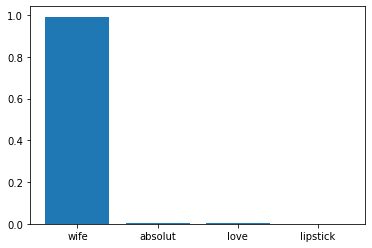

In [144]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(4)
sizes = [0.992, 0.003, 0.0035, 0.00034]

fig, ax = plt.subplots()
plt.bar(x, sizes)
plt.xticks(x, ('wife', 'absolut', 'love', 'lipstick'))
plt.show()

In [148]:
lp_val=modelda.logPerplexity(testtopic)
print(lp_val)

1752.4520993101976


Again we put the second review from online of a dress with one rating. Applied model and got the perplexity score. 

In [165]:
my_doc2="""Worst dress ever.This is the second Grace Karin dress that I ordered. It was "the advertised" cotton with spandex. Somehow, I expected to have the same experience when I ordered a second dress. This black flowered dress was significantly smaller despite ordering the same 2XL size. I couldn't even zip it AND the material was horrible. It was that thick cheapo polyester fabric. Even if it had fit, I would be sending in back because of the material! Very dissatisfied. 
I like the first one so much I am considering ordering a another color but I am hesitant. Thankful for Amazon easy returns.
"""
my_doc3="Beautiful color. I will buy again. Fitting is nice"

df_my_post2 = spark.createDataFrame([(1,my_doc2)],["ID","reviewText"])
df_my_post3= spark.createDataFrame([(2,my_doc3)],["ID","reviewText"])

from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame

def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

t=unionAll(df_my_post2, df_my_post3)

df_test2=t.select("ID", (removePunctuation(col('reviewText'))))

df_my_tokens2 = tokenizer.transform(df_test2)
df_my_finalTokens2 = swRemover.transform(df_my_tokens2).withColumn("words",
                                           stemmer_udf("filtered"))

my_countVectors2 = model.transform(df_my_finalTokens2)
testtopic2 = modelda.transform(my_countVectors2)

test_b=testtopic2.select("words", "topicDistribution")
test_b.show(5)


+--------------------+--------------------+
|               words|   topicDistribution|
+--------------------+--------------------+
|[worst, dress, ev...|[0.99170405931261...|
|[beauti, color, b...|[0.97567973102986...|
+--------------------+--------------------+



In [164]:
t.show(2)

+---+--------------------+
| ID|          reviewText|
+---+--------------------+
|  1|Worst dress ever....|
|  2|Beautiful color. ...|
+---+--------------------+



In [166]:
test_b.sort("topicDistribution").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words                                                                                                                                                        

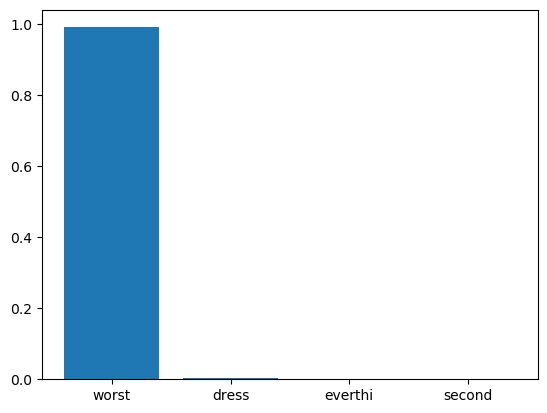

In [174]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(4)
sizes = [0.99, 0.004, 0.001, 0.001]

fig, ax = plt.subplots()
plt.bar(x, sizes)
plt.xticks(x, ('worst', 'dress', 'everthi', 'second'))
plt.show()

In [176]:
lp_val2=modelda.logPerplexity(testtopic2)
print(lp_val2)

1958.398278590617
